# HM2: Numerical Optimization for Logistic Regression.

### Name: Jeremiah McReynolds


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Logistic/paper/logistic.pdf)

2. Read, complete, and run my code.

3. **Implement mini-batch SGD** and evaluate the performance.

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
    * Missing **the output after execution** will not be graded.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo.  (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/HM2/HM2.html


## Grading criteria:

1. When computing the ```gradient``` and ```objective function value``` using a batch of samples, use **matrix-vector multiplication** rather than a FOR LOOP of **vector-vector multiplications**.

2. Plot ```objective function value``` against ```epochs```. In the plot, compare GD, SGD, and MB-SGD (with $b=8$ and $b=64$). The plot must look reasonable.

# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [2]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [3]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.00599541 -0.0772219   0.05311953 -0.10267199 -0.11280085 -0.07520036
  -0.09356309 -0.04568896]]
test std = 
[[0.9628841  1.08015784 1.16277686 1.02721513 0.90725758 0.98337328
  0.88812976 1.04503585]]


## 1.4. Add a dimension of all ones

In [4]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


# 2. Logistic regression model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

In [5]:
# Calculate the objective function value
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     objective function value (scalar)
def objective(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(-yxw) # n-by-1 matrix
    vec2 = numpy.log(1 + vec1) # n-by-1 matrix
    loss = numpy.mean(vec2) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    return loss + reg
    

In [6]:
# initialize w
d = x_train.shape[1]
w = numpy.zeros((d, 1))

# evaluate the objective function value at w
lam = 1E-6
objval0 = objective(w, x_train, y_train, lam)
print('Initial objective function value = ' + str(objval0))

Initial objective function value = 0.6931471805599453


# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ is $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [7]:
# Calculate the gradient
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     g: g: d-by-1 matrix, full gradient
def gradient(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(yxw) # n-by-1 matrix
    vec2 = numpy.divide(yx, 1+vec1) # n-by-d matrix
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w
    return g

In [8]:
# Gradient descent for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_iter: integer, the maximal iterations
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: d-by-1 matrix, the solution
#     objvals: a record of each iteration's objective value
def grad_descent(x, y, lam, stepsize, max_iter=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_iter) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_iter):
        objval = objective(w, x, y, lam)
        objvals[t] = objval
        print('Objective value at t=' + str(t) + ' is ' + str(objval))
        g = gradient(w, x, y, lam)
        w -= stepsize * g
    
    return w, objvals

Run gradient descent.

In [9]:
lam = 1E-6
stepsize = 1.0
w, objvals_gd = grad_descent(x_train, y_train, lam, stepsize)

Objective value at t=0 is 0.6931471805599453
Objective value at t=1 is 0.5922139650194567
Objective value at t=2 is 0.5527908013365109
Objective value at t=3 is 0.5324325666779745
Objective value at t=4 is 0.5201584115531052
Objective value at t=5 is 0.5120763332795266
Objective value at t=6 is 0.506452716598658
Objective value at t=7 is 0.5023909477787686
Objective value at t=8 is 0.4993773141346891
Objective value at t=9 is 0.497095308570258
Objective value at t=10 is 0.49533929952830835
Objective value at t=11 is 0.49397025032767394
Objective value at t=12 is 0.49289119687287963
Objective value at t=13 is 0.4920328235027183
Objective value at t=14 is 0.4913445634596334
Objective value at t=15 is 0.49078889369042683
Objective value at t=16 is 0.4903375616633504
Objective value at t=17 is 0.4899690246234452
Objective value at t=18 is 0.4896666733102589
Objective value at t=19 is 0.48941757642388634
Objective value at t=20 is 0.4892115784380354
Objective value at t=21 is 0.489040641779

## 3.2. Stochastic gradient descent (SGD)

Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [10]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    d = xi.shape[0]
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar
    
    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

In [11]:
# SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def sgd(x, y, lam, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

Run SGD.

In [12]:
lam = 1E-6
stepsize = 0.1
w, objvals_sgd = sgd(x_train, y_train, lam, stepsize)

Objective value at epoch t=0 is 0.549909197170275
Objective value at epoch t=1 is 0.5412261061620235
Objective value at epoch t=2 is 0.5283851271329794
Objective value at epoch t=3 is 0.526241608842444
Objective value at epoch t=4 is 0.5347373536634682
Objective value at epoch t=5 is 0.5192760036989409
Objective value at epoch t=6 is 0.5077787590280823
Objective value at epoch t=7 is 0.5164755398655625
Objective value at epoch t=8 is 0.5147526649647166
Objective value at epoch t=9 is 0.5082030510832276
Objective value at epoch t=10 is 0.5084341746103569
Objective value at epoch t=11 is 0.5053501417155059
Objective value at epoch t=12 is 0.5074966110912581
Objective value at epoch t=13 is 0.5031600105966421
Objective value at epoch t=14 is 0.5036648686929059
Objective value at epoch t=15 is 0.5025269000867402
Objective value at epoch t=16 is 0.5003565186613163
Objective value at epoch t=17 is 0.4982652299897176
Objective value at epoch t=18 is 0.49788342094938187
Objective value at epoc

# 4. Compare GD with SGD

Plot objective function values against epochs.

<ipython-input-13-9b8d8f4cdfb5>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
<ipython-input-13-9b8d8f4cdfb5>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
<ipython-input-13-9b8d8f4cdfb5>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xlabel('Epochs', FontSize=20)
<ipython-input-13-9b8d8f4cdfb5>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.ylabel('Objective Value', FontSize=20)
<ipython-input-13-9b8d8f4cdfb5>:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 

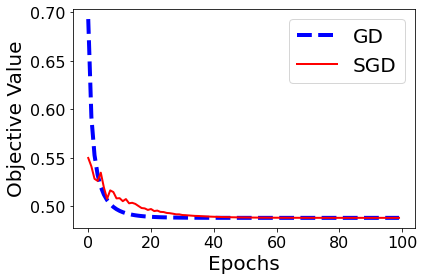

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1], ['GD', 'SGD'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)

# 5. Prediction

In [14]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

In [15]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.2359375


In [16]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.1875


# 6. Mini-batch SGD (fill the code)



## 6.1. Compute the objective $Q_I$ and its gradient using a batch of samples

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [17]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: d-by-1 matrix
#     xi: b-by-d matrix
#     yi: b-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def mb_stochastic_objective_gradient(w, xi, yi, lam, b):
    # Fill the function
    # Follow the implementation of stochastic_objective_gradient
    # Use matrix-vector multiplication; do not use FOR LOOP of vector-vector multiplications
    n,d = xi.shape
    yx = numpy.multiply(yi, xi)  # b by d matrix
    yxw = numpy.dot(yx, w)  # b x 1 vector

    # Solve objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # b x 1 vector
    reg = (lam / 2) * numpy.sum(w * w)  # scalar
    obj = (1/b) * numpy.sum(loss + reg)  # scalar

    # Calculate gradient
    z = (1 / (1 + numpy.exp(yxw)))  # b x 1 vector
    g_loss = numpy.multiply(z, -yx).T # d x b matrix
    g = (1/b) * numpy.sum(g_loss, axis=1) + (lam * w) # d x 1 vector 
    return obj, g

## 6.2. Implement mini-batch SGD

Hints:
1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_stochastic_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.


In [18]:
# Mini-Batch SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def mb_sgd(x, y, lam, b, stepsize, max_epoch=100, w=None):
    # Fill the function
    # Follow the implementation of sgd
    # Record one objective value per epoch (not per iteration!)
    n, d = x.shape
    objvals = numpy.zeros(max_epoch)
    if not w:
        w = numpy.zeros((d,1))
    
    for t in range(max_epoch):
        iters = int(n / b)
        indices = numpy.random.permutation(n)
        x_rand = x[indices, :]
        y_rand = y[indices, :]
        start = 0
        objval = 0
        for i in range(iters):
            end = start + b
            xi = x_rand[start:end, :]
            yi = y_rand[start:end, :]
            obj, g = mb_stochastic_objective_gradient(w, xi, yi, lam, b)
            objval += obj
            w -= stepsize * g
            start = end
            
        stepsize *= 0.9
        objval /= iters
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

## 6.3. Run MB-SGD

In [19]:
# MB-SGD with batch size b=8
lam = 1E-6 # do not change
b = 8 # do not change
stepsize = 0.1 # you must tune this parameter

w, objvals_mbsgd8 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch t=0 is 0.5514386610930482
Objective value at epoch t=1 is 0.5024558633550139
Objective value at epoch t=2 is 0.4956058018486065
Objective value at epoch t=3 is 0.4947687858257083
Objective value at epoch t=4 is 0.49514741028685083
Objective value at epoch t=5 is 0.4930674629325046
Objective value at epoch t=6 is 0.492523904595539
Objective value at epoch t=7 is 0.49237115987556496
Objective value at epoch t=8 is 0.4914203989724557
Objective value at epoch t=9 is 0.49186637885390966
Objective value at epoch t=10 is 0.49142175310936215
Objective value at epoch t=11 is 0.4910998586957295
Objective value at epoch t=12 is 0.4910002546311669
Objective value at epoch t=13 is 0.49042065638238697
Objective value at epoch t=14 is 0.49029862998515605
Objective value at epoch t=15 is 0.4902084366209616
Objective value at epoch t=16 is 0.48996555370894707
Objective value at epoch t=17 is 0.4896029779056866
Objective value at epoch t=18 is 0.4895212907262688
Objective value 

In [20]:
# MB-SGD with batch size b=64
lam = 1E-6 # do not change
b = 64 # do not change
stepsize = 0.675 # you must tune this parameter

w, objvals_mbsgd64 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch t=0 is 0.5690613835131503
Objective value at epoch t=1 is 0.5038483155490778
Objective value at epoch t=2 is 0.4961741627950735
Objective value at epoch t=3 is 0.4947172456586869
Objective value at epoch t=4 is 0.4919013492002649
Objective value at epoch t=5 is 0.49219829573759205
Objective value at epoch t=6 is 0.49214329310926186
Objective value at epoch t=7 is 0.49134206405225267
Objective value at epoch t=8 is 0.4902219910880472
Objective value at epoch t=9 is 0.4912097348099307
Objective value at epoch t=10 is 0.489979768433592
Objective value at epoch t=11 is 0.489832623435486
Objective value at epoch t=12 is 0.49014095178999995
Objective value at epoch t=13 is 0.48971852092239143
Objective value at epoch t=14 is 0.48954544970986297
Objective value at epoch t=15 is 0.4895538973526706
Objective value at epoch t=16 is 0.4895544308351577
Objective value at epoch t=17 is 0.48917380141908773
Objective value at epoch t=18 is 0.48932969508402147
Objective value 

# 7. Plot and compare GD, SGD, and MB-SGD

You are required to compare the following algorithms:

- Gradient descent (GD)

- SGD

- MB-SGD with b=8

- MB-SGD with b=64

Follow the code in Section 4 to plot ```objective function value``` against ```epochs```. There should be four curves in the plot; each curve corresponds to one algorithm.

Hint: Logistic regression with $\ell_2$-norm regularization is a strongly convex optimization problem. All the algorithms will converge to the same solution. **In the end, the ``objective function value`` of the 4 algorithms will be the same. If not the same, your implementation must be wrong. Do NOT submit wrong code and wrong result!**

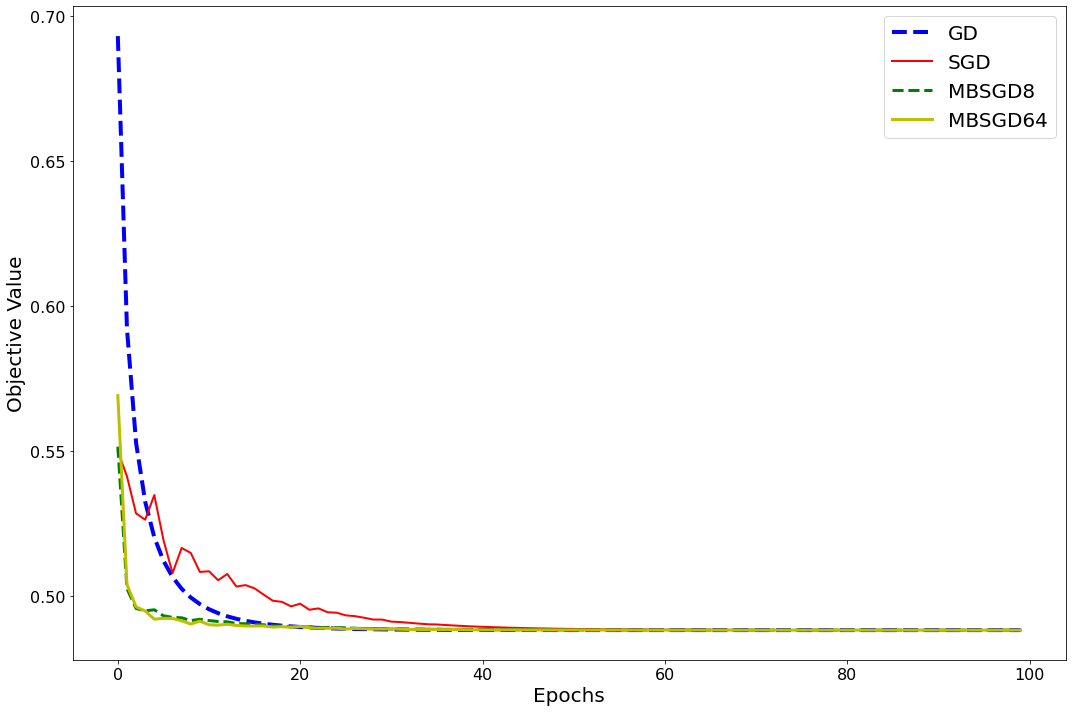

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(15,10))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))
epochs_mbsgd8 = range(len(objvals_mbsgd8))
epochs_mbsgd64 = range(len(objvals_mbsgd64))

line0 = plt.plot(epochs_gd, objvals_gd, '--b', linewidth=4)
line1 = plt.plot(epochs_sgd, objvals_sgd, '-r', linewidth=2)
line2 = plt.plot(epochs_mbsgd8, objvals_mbsgd8, '--g', linewidth=3)
line3 = plt.plot(epochs_mbsgd64, objvals_mbsgd64, '-y', linewidth=3)

plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Objective Value', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['GD', 'SGD', 'MBSGD8', 'MBSGD64'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd_mbsgd.pdf', format='pdf', dpi=1200)

# Prediction MBSGD

In [22]:
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.2375


In [23]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.1875
